<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Interesting Research
https://www.nature.com/articles/s41467-018-08066-0

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [98]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44005/44005.ncml')
ds = ds.sel(time=slice('2015-5-23','2022-5-23'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 44029)
Coordinates:
  * latitude                 (latitude) float32 43.2
  * longitude                (longitude) float32 -69.13
  * time                     (time) datetime64[ns] 2015-05-23T00:50:00 ... 20...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tempe

In [103]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
cov['sea_surface_temperature'] = cov['sea_surface_temperature'].rolling(24*14).mean().diff()
cov = cov.dropna()
print(cov)

                     time  sea_surface_temperature
336   2015-06-06 05:50:00                 0.001786
337   2015-06-06 06:50:00                 0.001488
338   2015-06-06 07:50:00                 0.001786
339   2015-06-06 08:50:00                 0.002381
340   2015-06-06 09:50:00                 0.002679
...                   ...                      ...
41855 2022-05-23 19:50:00                 0.011905
41856 2022-05-23 20:50:00                 0.012798
41857 2022-05-23 21:50:00                 0.013393
41858 2022-05-23 22:50:00                 0.013690
41859 2022-05-23 23:50:00                 0.012798

[41524 rows x 2 columns]


In [104]:
# Fit mixture model 
num_components = 5
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=100)
p = dpgmm_model.fit_predict(cov['sea_surface_temperature'].to_numpy().reshape(-1,1))

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[32254.  1774.   415.   293.  6788.]


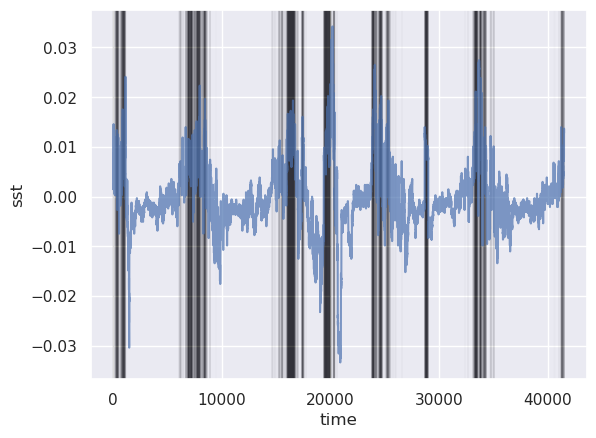

In [106]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.002) 
    
sns.lineplot(data=cov['sea_surface_temperature'].values, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

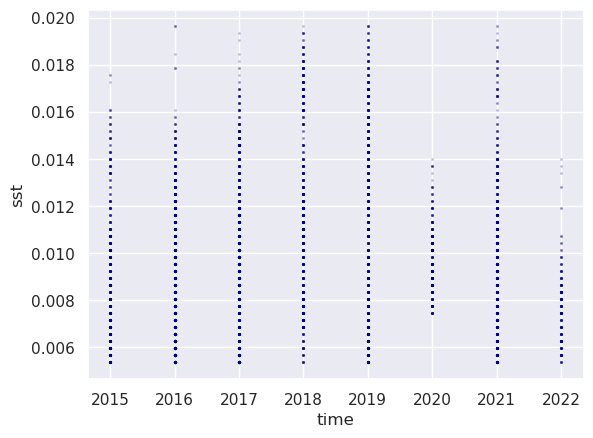

In [107]:
# Plot States Grouped by Year 
fig,ax=plt.subplots()
data={'2014':[],
      '2015':[],
      '2016':[],
      '2017':[],
      '2018':[],
      '2019':[],
      '2020':[],
      '2021':[],
      '2022':[],
      '2023':[]}

for M in range(len(p)): 
  if p[M] == p[-1]:
    yr = str(cov['time'].values[M])[:4]
    data[yr].append(cov['sea_surface_temperature'].values[M])

for cluster in data: 
    ax.scatter(x=np.full(len(data[cluster]), int(cluster)), y=data[cluster], alpha=0.15, label=cluster, color='darkblue', s=1.5)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()
